<h3 STYLE="background: #c2edff;padding: 0.5em;">Step 6. 機械学習で二値分類</h3>

<ol>
<li><a href="#1">「ワインの品質」データ読み込み</a>
<li><a href="#2">２群に分ける</a>
<li><a href="#3">説明変数と目的変数に分ける</a>
<li><a href="#4">訓練データとテストデータに分ける</a>
<li><a href="#5">ロジスティク回帰</a>
<li><a href="#6">いろんな機械学習手法を比較する</a>
</ol>

In [1]:
# 数値計算やデータフレーム操作に関するライブラリをインポートする
import numpy as np
import pandas as pd

In [2]:
# URL によるリソースへのアクセスを提供するライブラリをインポートする。
# import urllib # Python 2 の場合
import urllib.request # Python 3 の場合

<h3 STYLE="background: #c2edff;padding: 0.5em;"><a name="1">1. 「ワインの品質」データ読み込み</a></h3>

データは <a href="http://archive.ics.uci.edu/ml/index.php" target="_blank">UC Irvine Machine Learning Repository</a> から取得したものを少し改変しました。

* 赤ワイン https://raw.githubusercontent.com/chemo-wakate/tutorial-6th/master/beginner/data/winequality-red.txt

* 白ワイン https://raw.githubusercontent.com/chemo-wakate/tutorial-6th/master/beginner/data/winequality-white.txt

<h4 style="border-bottom: solid 1px black;">　<a href="http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality.names">詳細</a></h4>

<ol>
<li>fixed acidity : 不揮発酸濃度（ほぼ酒石酸濃度）
<li>volatile acidity : 揮発酸濃度（ほぼ酢酸濃度）
<li>citric acid : クエン酸濃度
<li>residual sugar : 残存糖濃度
<li>chlorides : 塩化物濃度
<li>free sulfur dioxide : 遊離亜硫酸濃度
<li>total sulfur dioxide : 亜硫酸濃度
<li>density : 密度
<li>pH : pH
<li>sulphates : 硫酸塩濃度
<li>alcohol : アルコール度数
<li>quality (score between 0 and 10) : 0-10 の値で示される品質のスコア
</ol>

In [3]:
# ウェブ上のリソースを指定する
url = 'https://raw.githubusercontent.com/chemo-wakate/tutorial-6th/master/beginner/data/winequality-red.txt'
# 指定したURLからリソースをダウンロードし、名前をつける。
# urllib.urlretrieve(url, 'winequality-red.csv') # Python 2 の場合
urllib.request.urlretrieve(url, 'winequality-red.txt') # Python 3 の場合

('winequality-red.txt', <http.client.HTTPMessage at 0x106640ef0>)

In [4]:
# データの読み込み
df1 = pd.read_csv('winequality-red.txt', sep='\t', index_col=0) 

In [5]:
df1.head() # 先頭５行だけ表示

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5


<h3 STYLE="background: #c2edff;padding: 0.5em;"><a name="2">2. ２群に分ける</a></h3>

In [6]:
toy_data = pd.DataFrame([[1,4,7,10,13,16],[2,5,8,11,14,27],[3,6,9,12,15,17],[21,24,27,20,23,26]],
                   index = ['i1','i2','i3', 'i4'],
                   columns = list("abcdef"))

In [7]:
toy_data

,a,b,c,d,e,f
i1,1,4,7,10,13,16
i2,2,5,8,11,14,27
i3,3,6,9,12,15,17
i4,21,24,27,20,23,26


In [8]:
toy_data[toy_data['f'] < 20]

,a,b,c,d,e,f
i1,1,4,7,10,13,16
i3,3,6,9,12,15,17


In [9]:
toy_data[toy_data['f'] >= 20]

,a,b,c,d,e,f
i2,2,5,8,11,14,27
i4,21,24,27,20,23,26


In [10]:
pd.DataFrame(toy_data[toy_data['f'] >= 20]['b'])

,b
i2,5
i4,24


In [11]:
toy_data['class'] = [0 if i < 20 else 1 for i in toy_data['f'].tolist()]

In [12]:
toy_data

,a,b,c,d,e,f,class
i1,1,4,7,10,13,16,0
i2,2,5,8,11,14,27,1
i3,3,6,9,12,15,17,0
i4,21,24,27,20,23,26,1


In [13]:
df1[df1['quality'] <= 5].head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


In [14]:
df1[df1['quality'] > 5].head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7,7.3,0.65,0.00,1.2,0.065,15,21,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9,18,0.9968,3.36,0.57,9.5,7
16,8.5,0.28,0.56,1.8,0.092,35,103,0.9969,3.30,0.75,10.5,7
19,7.9,0.32,0.51,1.8,0.341,17,56,0.9969,3.04,1.08,9.2,6


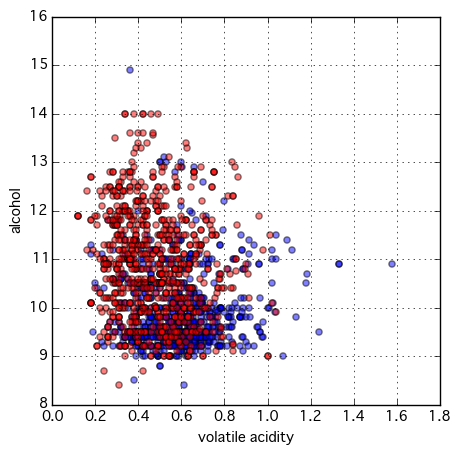

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
df1[df1['quality'] <= 5].plot(kind='scatter', x=u'volatile acidity', y=u'alcohol', ax=ax, 
                              c='blue', alpha=0.5)
df1[df1['quality'] >  5].plot(kind='scatter', x=u'volatile acidity', y=u'alcohol', ax=ax, 
                              c='red', alpha=0.5, grid=True, figsize=(5,5))
plt.show()

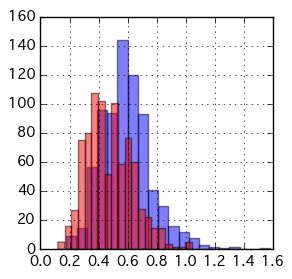

In [16]:
df1[df1['quality'] <= 5]['volatile acidity'].hist(figsize=(3, 3), bins=20, alpha=0.5, color='blue')
df1[df1['quality'] >  5]['volatile acidity'].hist(figsize=(3, 3), bins=20, alpha=0.5, color='red')

In [17]:
# 対応のないt検定
import numpy as np
import scipy as sp
from scipy import stats

significance = 0.05
X = df1[df1['quality'] <= 5]['volatile acidity'].tolist()
Y = df1[df1['quality'] >  5]['volatile acidity'].tolist()

t, p = stats.ttest_ind(X, Y)

print( "t 値は %(t)s" %locals() )
print( "確率は %(p)s" %locals() )

if p < significance:
    print("有意水準 %(significance)s で、有意な差があります" %locals())
else:
    print("有意水準 %(significance)s で、有意な差がありません" %locals())

t 値は 13.5655002264
確率は 9.33662078115e-40
有意水準 0.05 で、有意な差があります


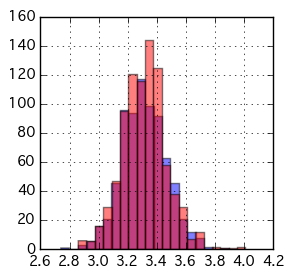

In [18]:
df1[df1['quality'] <= 5]['pH'].hist(figsize=(3, 3), bins=20, alpha=0.5, color='blue')
df1[df1['quality'] >  5]['pH'].hist(figsize=(3, 3), bins=20, alpha=0.5, color='red')

In [19]:
# 対応のないt検定
import numpy as np
import scipy as sp
from scipy import stats

significance = 0.05
X = df1[df1['quality'] <= 5]['pH'].tolist()
Y = df1[df1['quality'] >  5]['pH'].tolist()

t, p = stats.ttest_ind(X, Y)

print( "t 値は %(t)s" %locals() )
print( "確率は %(p)s" %locals() )

if p < significance:
    print("有意水準 %(significance)s で、有意な差があります" %locals())
else:
    print("有意水準 %(significance)s で、有意な差がありません" %locals())

t 値は 0.130437581408
確率は 0.896236662563
有意水準 0.05 で、有意な差がありません


In [20]:
df1['class'] = [0 if i <= 5 else 1 for i in df1['quality'].tolist()]

In [21]:
df1.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,class
0,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,0


In [22]:
# それぞれに与える色を決める。
color_codes = {0:'#0000FF', 1:'#FF0000'}
colors = [color_codes[x] for x in df1['class'].tolist()]

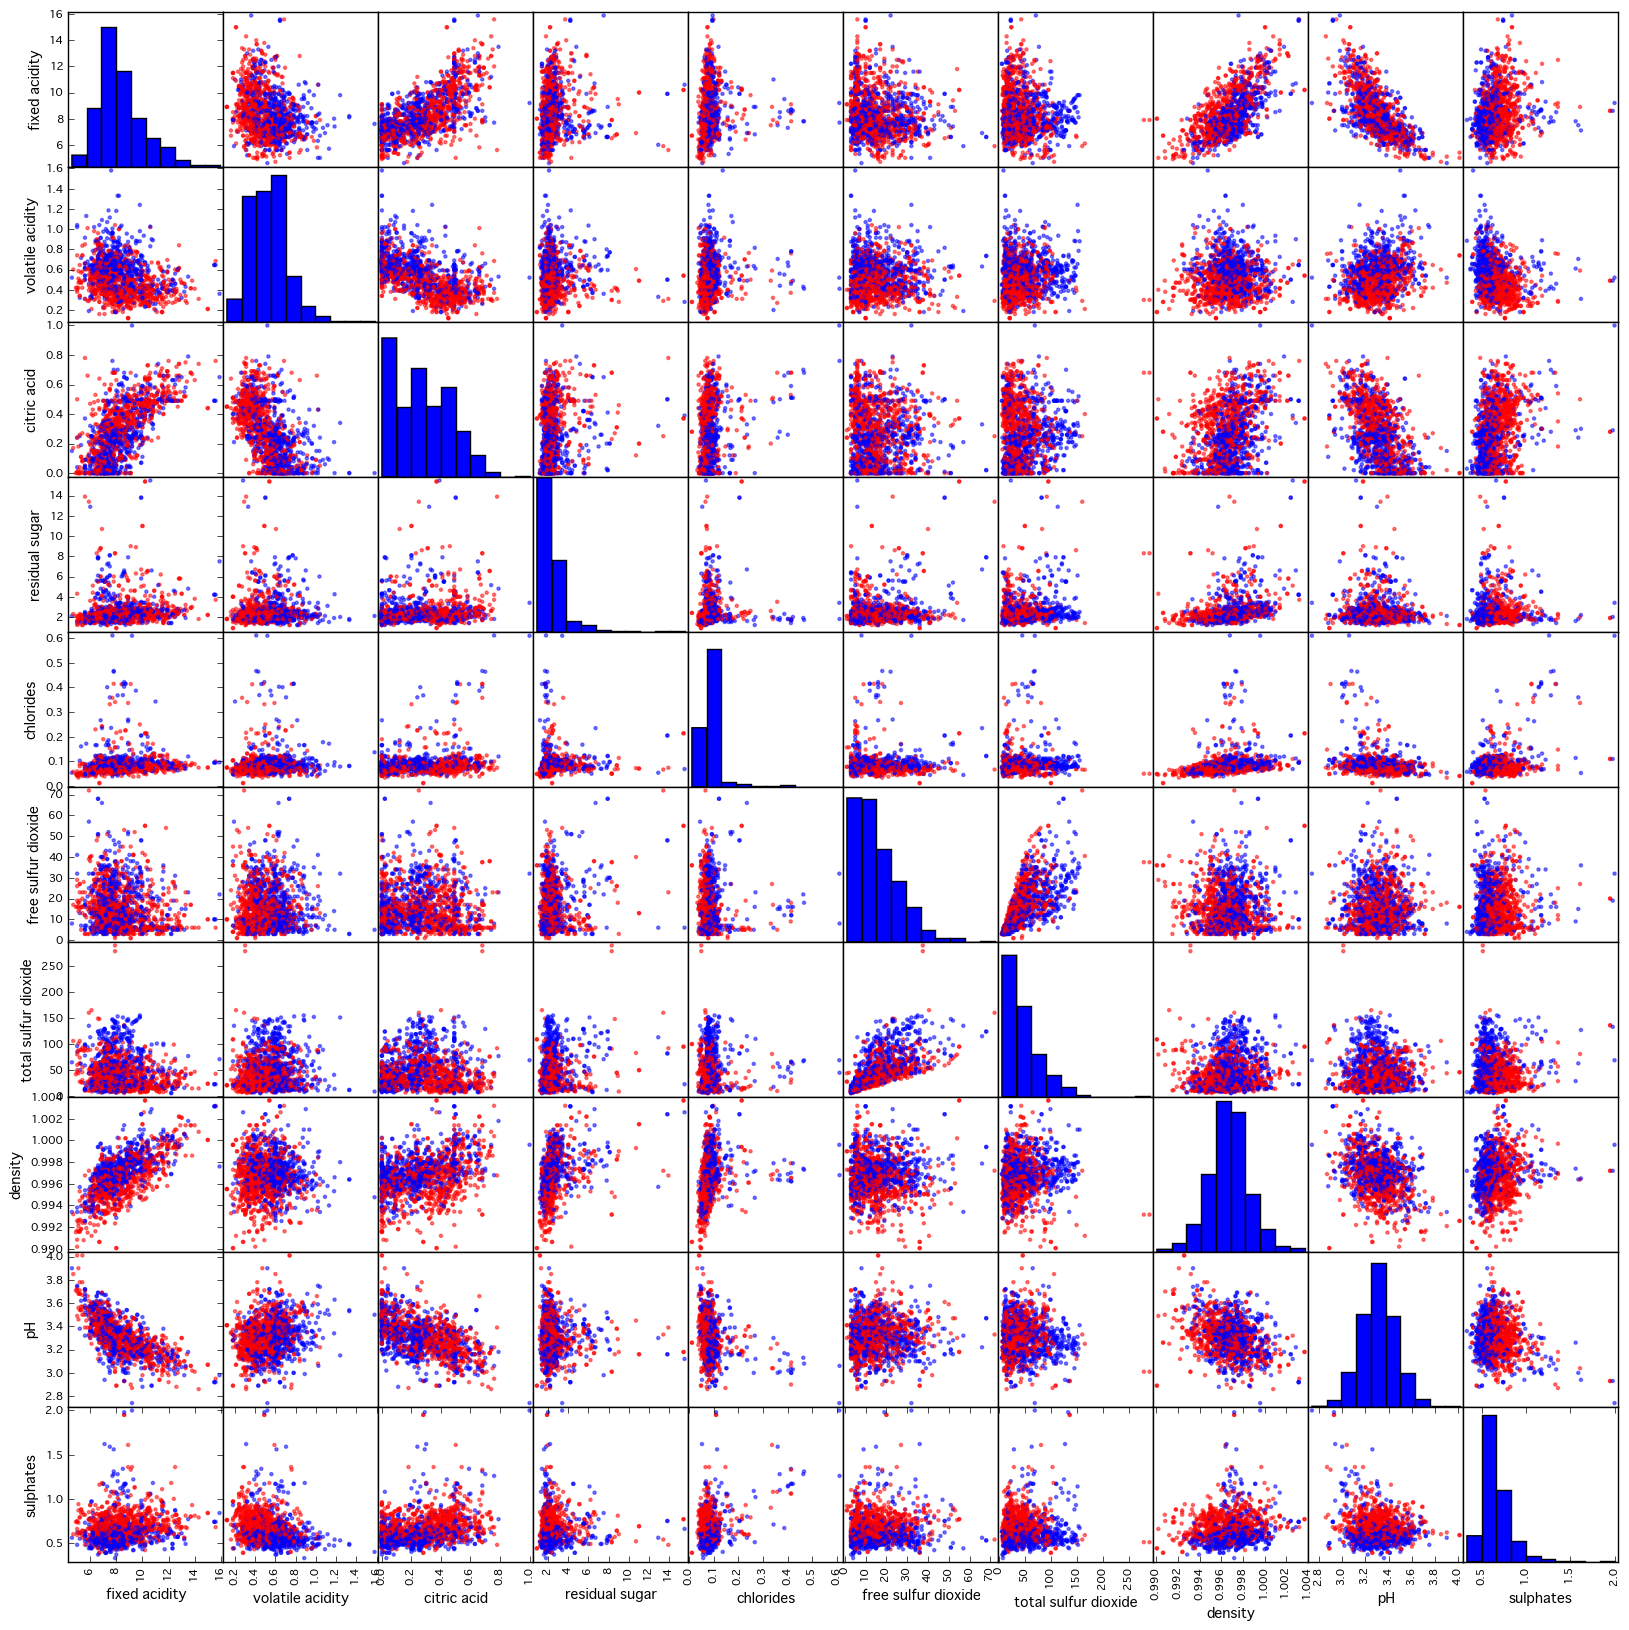

In [23]:
from pandas.tools import plotting # 高度なプロットを行うツールのインポート
plotting.scatter_matrix(df1.dropna(axis=1)[df1.columns[:10]], figsize=(20, 20), color=colors, alpha=0.5) 
plt.show()

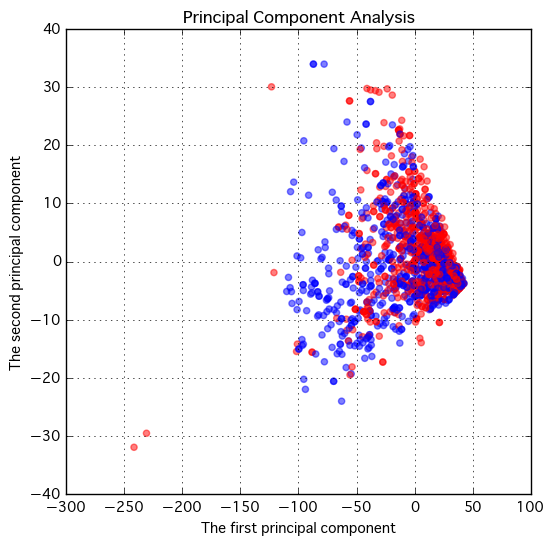

In [24]:
from sklearn.decomposition import PCA #主成分分析器
pca = PCA()
pca.fit(df1.iloc[:, :10])
# データを主成分空間に写像 = 次元圧縮
feature = pca.transform(df1.iloc[:, :10])
plt.figure(figsize=(6, 6))
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.5, color=colors)
plt.title("Principal Component Analysis")
plt.xlabel("The first principal component")
plt.ylabel("The second principal component")
plt.grid()
plt.show()

In [25]:
dfs = df1.apply(lambda x: (x-x.mean())/x.std(), axis=0).fillna(0)

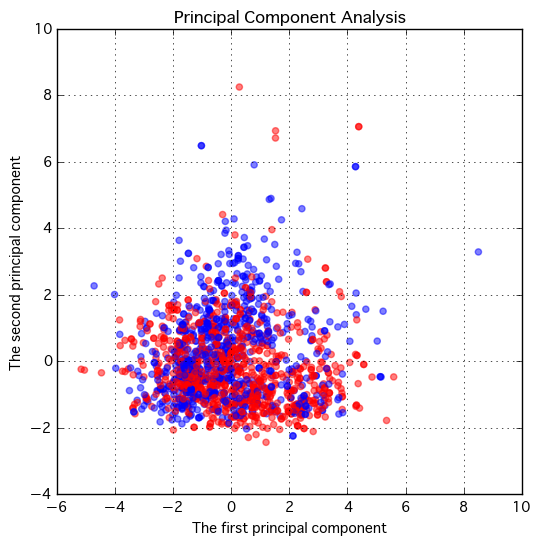

In [26]:
from sklearn.decomposition import PCA #主成分分析器
pca = PCA()
pca.fit(dfs.iloc[:, :10])
# データを主成分空間に写像 = 次元圧縮
feature = pca.transform(dfs.iloc[:, :10])
plt.figure(figsize=(6, 6))
plt.scatter(feature[:, 0], feature[:, 1], alpha=0.5, color=colors)
plt.title("Principal Component Analysis")
plt.xlabel("The first principal component")
plt.ylabel("The second principal component")
plt.grid()
plt.show()

<h3 STYLE="background: #c2edff;padding: 0.5em;"><a name="3">3. 説明変数と目的変数に分ける</a></h3>

In [27]:
X = dfs.iloc[:, :10]
y = df1.iloc[:, 12]

In [28]:
X.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
0,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025
1,-0.298454,1.966827,-1.391037,0.043403,0.223805,0.872365,0.624168,0.028252,-0.719708,0.128910
2,-0.298454,1.296660,-1.185699,-0.169374,0.096323,-0.083643,0.228975,0.134222,-0.331073,-0.048074
3,1.654339,-1.384011,1.483689,-0.453077,-0.264878,0.107558,0.411372,0.664069,-0.978798,-0.461036
4,-0.528194,0.961576,-1.391037,-0.453077,-0.243630,-0.466047,-0.379014,0.558100,1.288240,-0.579025


In [29]:
pd.DataFrame(y).T

,0,1,2,3,4,5,6,7,8,9,...,1589,1590,1591,1592,1593,1594,1595,1596,1597,1598
class,0,0,0,1,0,0,0,1,1,0,...,0,1,1,1,1,0,1,1,0,1


<h3 STYLE="background: #c2edff;padding: 0.5em;"><a name="4">4. 訓練データとテストデータに分ける</a></h3>

In [30]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

In [31]:
X_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates
395,2.113819,-0.881385,2.510377,1.178212,-0.456101,-0.848450,-0.257416,1.935704,-0.590163,-0.343047
1382,-0.183584,0.403103,-0.261680,-0.311225,-0.158642,0.872365,1.779347,-0.326746,-0.071983,-0.991988
1476,0.907683,-0.155370,1.175683,7.987070,2.497242,3.071185,1.080160,3.005997,-0.978798,0.541872
247,-0.068714,0.403103,-0.518352,-0.169374,-0.328619,-0.466047,0.806565,-0.236672,-0.719708,-1.227966
429,2.573300,1.743438,1.843030,-0.098449,0.011334,-0.274845,-0.348615,1.564811,-1.367433,-0.343047


In [32]:
pd.DataFrame(y_train).T

,395,1382,1476,247,429,219,868,179,660,573,...,1348,905,190,95,860,1563,169,1041,958,755
class,1,0,0,0,1,0,1,0,1,0,...,0,0,0,1,0,0,0,1,1,1


<h3 STYLE="background: #c2edff;padding: 0.5em;"><a name="5">5. ロジスティック回帰</a></h3>

In [33]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression() #モデルの生成
clf.fit(X_train, y_train) #学習

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [34]:
#学習したモデルの精度
clf.score(X_train,y_train)

0.73722627737226276

In [35]:
clf.score(X_test,y_test)

0.72812500000000002

In [36]:
y_predict = clf.predict(X_test)

In [37]:
pd.DataFrame(y_predict).T

,0,1,2,3,4,5,6,7,8,9,...,630,631,632,633,634,635,636,637,638,639
0,1,1,1,1,1,1,1,1,0,1,...,1,0,1,1,1,0,0,0,1,0


In [38]:
from sklearn.metrics import confusion_matrix
# 予測と正解の比較。第一引数が行、第二引数が列を表す。
pd.DataFrame(confusion_matrix(y_predict, y_test), index=['predicted 0', 'predicted 1'], columns=['real 0', 'real 1'])

,real 0,real 1
predicted 0,220,87
predicted 1,87,246


<h3 STYLE="background: #c2edff;padding: 0.5em;"><a name="6">6. いろんな機械学習手法を比較する</a></h3>

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.lda import LDA
from sklearn.qda import QDA
names = ["Logistic Regression", "Nearest Neighbors", 
         "Linear SVM", "Polynomial SVM", "RBF SVM", "Sigmoid SVM", 
         "Decision Tree","Random Forest", "AdaBoost", "Naive Bayes", 
         "Linear Discriminant Analysis","Quadratic Discriminant Analysis"]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(kernel="linear"),
    SVC(kernel="poly"),
    SVC(kernel="rbf"),
    SVC(kernel="sigmoid"),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    LDA(),
    QDA()]

In [40]:
result = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score1 = clf.score(X_train, y_train)
    score2 = clf.score(X_test, y_test)
    result.append([score1, score2])

df_result = pd.DataFrame(result, columns=['train', 'test'], index=names).sort('test', ascending=False)

In [41]:
df_result

,train,test
Random Forest,0.986444,0.750000
RBF SVM,0.812304,0.729688
Linear Discriminant Analysis,0.741397,0.729688
Logistic Regression,0.737226,0.728125
Linear SVM,0.743483,0.721875
AdaBoost,0.802920,0.720313
Decision Tree,1.000000,0.704688
Nearest Neighbors,0.810219,0.696875
Quadratic Discriminant Analysis,0.701773,0.696875
Polynomial SVM,0.771637,0.689063


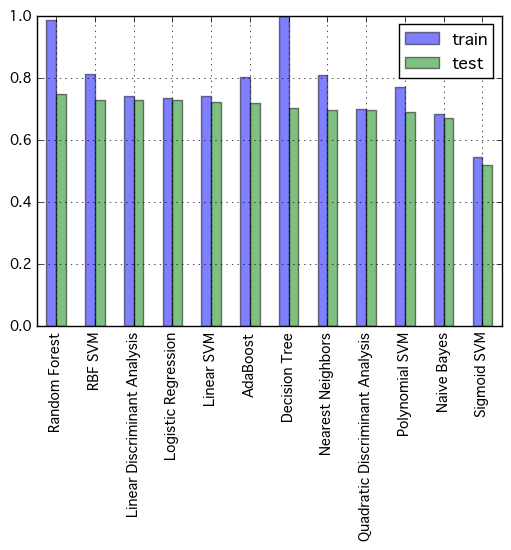

In [42]:
df_result.plot(kind='bar', alpha=0.5, grid=True)

In [43]:
result = []
for trial in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        score1 = clf.score(X_train, y_train)
        score2 = clf.score(X_test, y_test)
        result.append([name, score1, score2])

df_result = pd.DataFrame(result, columns=['classifier', 'train', 'test'])

In [44]:
df_result

,classifier,train,test
0,Logistic Regression,0.734098,0.729688
1,Nearest Neighbors,0.796663,0.700000
2,Linear SVM,0.736184,0.712500
3,Polynomial SVM,0.754953,0.718750
4,RBF SVM,0.779979,0.753125
5,Sigmoid SVM,0.527633,0.545312
6,Decision Tree,1.000000,0.743750
7,Random Forest,0.992701,0.756250
8,AdaBoost,0.802920,0.710938
9,Naive Bayes,0.670490,0.687500


In [45]:
df_result_mean = df_result.groupby('classifier').mean().sort('test', ascending=False)

In [46]:
df_result_mean

,train,test
classifier,,
Random Forest,0.986966,0.762031
RBF SVM,0.798332,0.735469
Linear Discriminant Analysis,0.742231,0.721875
Logistic Regression,0.740876,0.721719
Decision Tree,1.000000,0.719219
Linear SVM,0.740459,0.718125
AdaBoost,0.793326,0.716875
Polynomial SVM,0.761731,0.701094
Quadratic Discriminant Analysis,0.729197,0.697031


In [47]:
errors = df_result.groupby('classifier').std()
errors

,train,test
classifier,,
AdaBoost,0.009376,0.011571
Decision Tree,0.000000,0.016037
Linear Discriminant Analysis,0.011410,0.013010
Linear SVM,0.009738,0.016358
Logistic Regression,0.008346,0.016690
Naive Bayes,0.014340,0.013952
Nearest Neighbors,0.011867,0.010444
Polynomial SVM,0.008021,0.015918
Quadratic Discriminant Analysis,0.014821,0.017883


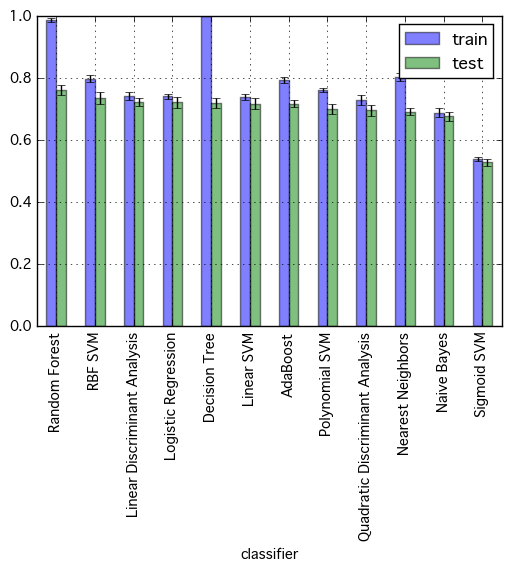

In [48]:
df_result_mean.plot(kind='bar', alpha=0.5, grid=True, yerr=errors)

<h4 style="padding: 0.25em 0.5em;color: #494949;background: transparent;border-left: solid 5px #7db4e6;"><a name="4">練習6.1</a></h4>

白ワインのデータ(https://raw.githubusercontent.com/chemo-wakate/tutorial-6th/master/beginner/data/winequality-white.txt) についても同様に機械学習による二値分類を行なってください。

In [42]:
# 練習6.1